## History

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Problem definition

Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

## Assumptions

- #### More survivals are women and children
- #### More survivals are 1st class passengers

## Import Python libs

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Utils
import string

# ML 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Read,  analyse and clean data

In [2]:
# read and display data
titanic = pd.read_csv("titanic.csv")

print(titanic.shape)
titanic.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- ### Show distributions

In [3]:
survived = titanic[titanic.Survived == 1]
died = titanic[titanic.Survived == 0]

males = titanic[titanic.Sex == 'male']
females = titanic[titanic.Sex == 'female']

fclass = titanic[titanic.Pclass == 1]
sclass = titanic[titanic.Pclass == 2]
tclass = titanic[titanic.Pclass == 3]

print("Survived:", len(survived))
print("Died:", len(died))
print("Survival rate:", titanic.Survived.mean())

print("\n")

print("Males:", len(males))
print("Females:", len(females))
print("Average age:", round(titanic.Age.mean()))
print("Max age:", titanic.Age.max())
print("Min age:", titanic.Age.min())
print("First Class:", len(fclass))
print("Second Class:", len(sclass))
print("Third Class:", len(tclass))

Survived: 342
Died: 549
Survival rate: 0.3838383838383838


Males: 577
Females: 314
Average age: 30
Max age: 80.0
Min age: 0.42
First Class: 216
Second Class: 184
Third Class: 491


In [4]:
# View data excluding NaN values
titanic.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lindblom, Miss. Augusta Charlotta",male,CA. 2343,G6,S
freq,1,577,7,4,644


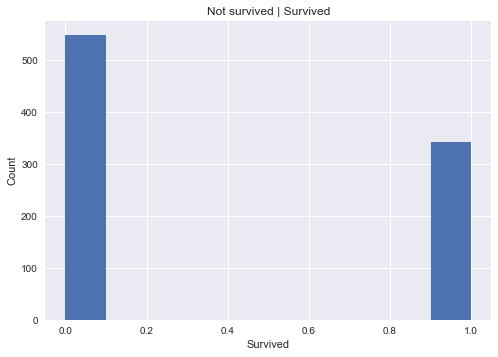

In [5]:
plt.hist(titanic.Survived)
plt.title("Not survived | Survived")
plt.xlabel("Survived")
plt.ylabel("Count")

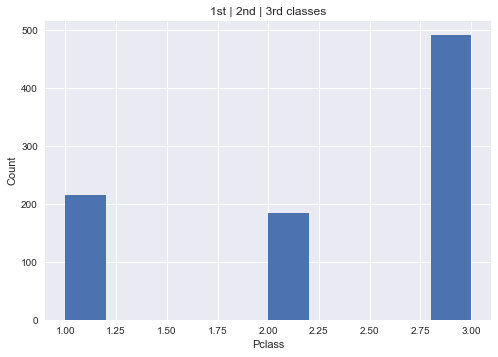

In [6]:
plt.hist(titanic.Pclass)
plt.title("1st | 2nd | 3rd classes")
plt.xlabel("Pclass")
plt.ylabel("Count")

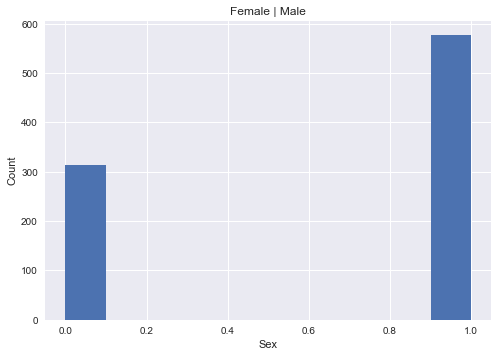

In [7]:
labels = LabelEncoder().fit_transform(titanic.Sex)
plt.hist(labels)
plt.title("Female | Male")
plt.xlabel("Sex")
plt.ylabel("Count")

In [8]:
# more than 68% of the survivals are women
pd.crosstab(titanic['Survived'], titanic['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


In [9]:
# about 39% of survivals are 1st class passengers
pd.crosstab(titanic['Survived'], titanic['Pclass'])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [10]:
# Average age survived/not survived
titanic[['Survived', 'Age']].groupby(['Survived'], as_index=False).mean().sort_values(by='Age', ascending=False)

,Survived,Age
0,0,30.626179
1,1,28.343690


- ### Show correlations

In [11]:
# assume that the most of survivals are women
print(titanic.groupby(["Survived", "Sex"]).size())
titanic[['Survived', 'Sex']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64


,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
# assume that there are more survivals in 1st class
print(titanic.groupby(["Survived", "Pclass"]).size())
titanic[['Survived', 'Pclass']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
dtype: int64


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
# more survivals are with 1, 2 sibings/spouses
titanic[['Survived', 'SibSp']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [14]:
titanic[titanic.SibSp == 8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [15]:
titanic[['Survived', 'Parch']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Feature engineering


In [16]:
# extract title from Name and create new feature
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

In [17]:
titles = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
            'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
            'Don', 'Jonkheer', 'Dona']
titanic['Title'] = titanic.Name.map(lambda x: substrings_in_string(x, titles))
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [18]:
# replace all titles with Mr, Mrs, Miss, Master
def replace_titles(x):
    title = x.Title
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x.Sex == 'male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

titanic.Title = titanic.apply(replace_titles, axis = 1)

In [19]:
# confirms that with Master title are children with average age of 4
titanic[['Title', 'Age']].groupby(['Title'], as_index=False).mean().sort_values(by='Age', ascending=False)

,Title,Age
3,Mrs,35.634783
2,Mr,32.984412
1,Miss,21.835616
0,Master,4.574167


In [20]:
titanic[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.795455
1,Miss,0.703297
0,Master,0.575000
2,Mr,0.160149


In [21]:
# convert titles to numeric values
titanic.Title = LabelEncoder().fit_transform(titanic.Title)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2


In [22]:
# convert genders to numeric values
titanic.Sex = LabelEncoder().fit_transform(titanic.Sex)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2


In [23]:
print(titanic.Embarked.unique())

['S' 'C' 'Q' nan]


In [24]:
# convert ports into numerics
titanic.Embarked = titanic.Embarked.fillna("Unknown") 
titanic.Embarked = LabelEncoder().fit_transform(titanic.Embarked)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,2


In [25]:
# remove unnecesary attributes and null values from dataset
filter_arr = ["PassengerId", "Ticket", "Name"]
titanic = titanic.drop(filter_arr, axis = 1)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,NaN,2,2
1,1,1,0,38.0,1,0,71.2833,C85,0,3
2,1,3,0,26.0,0,0,7.9250,NaN,2,1
3,1,1,0,35.0,1,0,53.1000,C123,2,3
4,0,3,1,35.0,0,0,8.0500,NaN,2,2


In [26]:
# create new feature FamilySize based on SibSp and Parch columns
titanic["FamilySize"] = titanic.SibSp + titanic.Parch
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,1,22.0,1,0,7.2500,NaN,2,2,1
1,1,1,0,38.0,1,0,71.2833,C85,0,3,1
2,1,3,0,26.0,0,0,7.9250,NaN,2,1,0
3,1,1,0,35.0,1,0,53.1000,C123,2,3,1
4,0,3,1,35.0,0,0,8.0500,NaN,2,2,0


In [27]:
# create new feature HasFamily based on FamilySize
titanic['HasFamily'] = 0
titanic.loc[titanic['FamilySize'] > 0, 'HasFamily'] = 1
titanic = titanic.drop(["SibSp", "Parch", "FamilySize"], axis = 1)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,HasFamily
0,0,3,1,22.0,7.2500,NaN,2,2,1
1,1,1,0,38.0,71.2833,C85,0,3,1
2,1,3,0,26.0,7.9250,NaN,2,1,0
3,1,1,0,35.0,53.1000,C123,2,3,1
4,0,3,1,35.0,8.0500,NaN,2,2,0


In [28]:
# based on cabin number create new feature HasCabin
titanic.Cabin = titanic.Cabin.fillna("Unknown")
titanic["HasCabin"] = 0
titanic.loc[titanic['Cabin'] != 'Unknown', 'HasCabin'] = 1
titanic = titanic.drop("Cabin", axis = 1)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,HasFamily,HasCabin
0,0,3,1,22.0,7.2500,2,2,1,0
1,1,1,0,38.0,71.2833,0,3,1,1
2,1,3,0,26.0,7.9250,2,1,0,0
3,1,1,0,35.0,53.1000,2,3,1,1
4,0,3,1,35.0,8.0500,2,2,0,0


In [29]:
titanic.Fare.fillna(titanic.Fare.dropna().median(), inplace=True)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,HasFamily,HasCabin
0,0,3,1,22.0,7.2500,2,2,1,0
1,1,1,0,38.0,71.2833,0,3,1,1
2,1,3,0,26.0,7.9250,2,1,0,0
3,1,1,0,35.0,53.1000,2,3,1,1
4,0,3,1,35.0,8.0500,2,2,0,0


In [30]:
# create new feature FareRange and based on ranges transform Fare into numeric
titanic['FareRange'] = pd.qcut(titanic.Fare, 4)
titanic.Fare = LabelEncoder().fit_transform(titanic.FareRange) # 2 1 3 2 10   1 2 2 3 10
titanic = titanic.drop("FareRange", axis = 1)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,HasFamily,HasCabin
0,0,3,1,22.0,3,2,2,1,0
1,1,1,0,38.0,1,0,3,1,1
2,1,3,0,26.0,2,2,1,0,0
3,1,1,0,35.0,1,2,3,1,1
4,0,3,1,35.0,2,2,2,0,0


In [31]:
titanic.Age.fillna(titanic.Age.dropna().median(), inplace=True)
titanic.head()
titanic['AgeRange'] = pd.qcut(titanic.Age, 4)
titanic.Age = LabelEncoder().fit_transform(titanic.AgeRange)
titanic = titanic.drop("AgeRange", axis = 1)
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,HasFamily,HasCabin
0,0,3,1,3,3,2,2,1,0
1,1,1,0,2,1,0,3,1,1
2,1,3,0,0,2,2,1,0,0
3,1,1,0,1,1,2,3,1,1
4,0,3,1,1,2,2,2,0,0


In [32]:
attributes = titanic.drop("Survived", axis = 1)
labels = titanic.Survived

attributes.shape, labels.shape

((891, 8), (891,))

In [33]:
# split data into train and test sets
attributes_train, attributes_test, labels_train, labels_test = train_test_split(attributes, labels, train_size=0.7, stratify=labels)

attributes_train.shape, attributes_test.shape, labels_train.shape, labels_test.shape

((623, 8), (268, 8), (623,), (268,))

## Create, train, predict and score models

In [34]:
# init and fit grid search
def tuneModel(estimator, params):
    grid = GridSearchCV(estimator, params, cv = 10)
    grid.fit(attributes_train, labels_train)
    
    print(grid.best_estimator_)
    return grid.best_estimator_

In [35]:
def scoreModel(estimator):
    acc_train = estimator.score(attributes_train, labels_train)
    acc_test = estimator.score(attributes_test, labels_test)
    print("Train accuracy score:", acc_train)
    print("Test accuracy score:", acc_test)
    
    predicted = estimator.predict(attributes_test)
    print("Precision score", precision_score(labels_test, predicted, average = "weighted"))
    print("Recall score", recall_score(labels_test, predicted, average = "weighted"))
    print("F1 score", f1_score(labels_test, predicted, average = "weighted"))
    print("Confusion matrix:\n", confusion_matrix(labels_test, predicted))
    
    fpr, tpr, _ = roc_curve(labels_test, predicted)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle = "--")
    
    return (acc_train, acc_test)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train accuracy score: 0.786516853933
Test accuracy score: 0.809701492537
Precision score 0.808514246947
Recall score 0.809701492537
F1 score 0.806365962131
Confusion matrix:
 [[147  18]
 [ 33  70]]


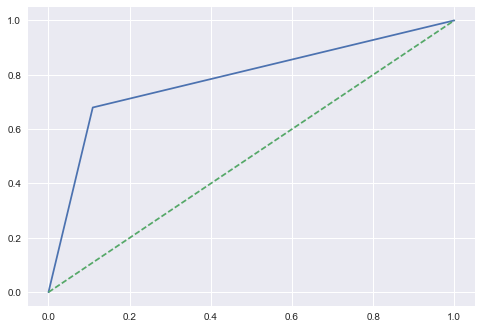

In [36]:
# Logistic Regression
log_regr = LogisticRegression()
params = {"penalty": ["l1", "l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "fit_intercept": [True, False]}

log_regr = tuneModel(log_regr, params)
acc_log = scoreModel(log_regr)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Train accuracy score: 0.84911717496
Test accuracy score: 0.791044776119
Precision score 0.791860468603
Recall score 0.791044776119
F1 score 0.784350736539
Confusion matrix:
 [[149  16]
 [ 40  63]]


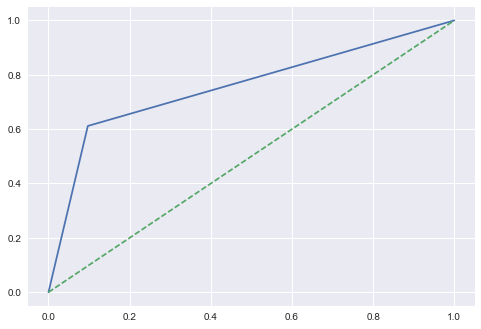

In [37]:
# DecisionTree
decision_tree = DecisionTreeClassifier()
params = {"criterion": ["gini", "entropy"], "max_depth": [None, 2, 3, 5] }
decision_tree = tuneModel(decision_tree, params)
acc_tree = scoreModel(decision_tree)

Train accuracy score: 0.890850722311
Test accuracy score: 0.787313432836
Precision score 0.785457296955
Recall score 0.787313432836
F1 score 0.782958065443
Confusion matrix:
 [[145  20]
 [ 37  66]]


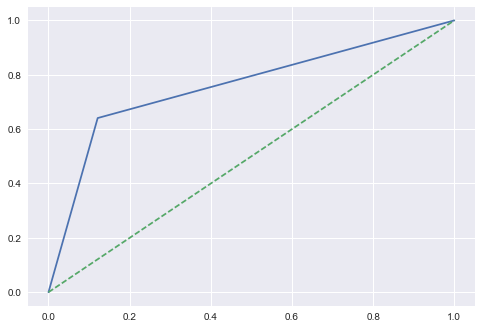

In [38]:
# AdaBoost
tree = DecisionTreeClassifier(max_depth = 1)
ada = AdaBoostClassifier(base_estimator = decision_tree, n_estimators = 100, learning_rate = 0.1)
ada.fit(attributes_train, labels_train)
acc_ada = scoreModel(ada)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Train accuracy score: 0.855537720706
Test accuracy score: 0.817164179104
Precision score 0.815616068593
Recall score 0.817164179104
F1 score 0.815414750514
Confusion matrix:
 [[145  20]
 [ 29  74]]


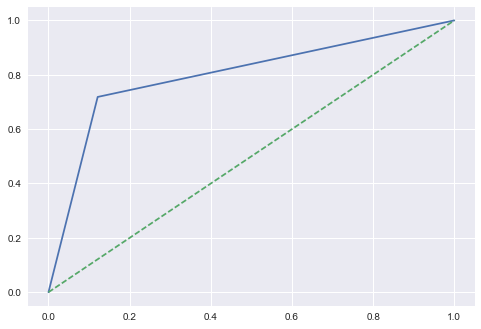

In [39]:
# Random Forest
random_forest = RandomForestClassifier()
params = {"criterion": ["gini", "entropy"], "n_estimators": [2, 5, 10, 25], "max_depth": [None, 2, 3, 5]}
random_forest = tuneModel(random_forest, params)
acc_forest = scoreModel(random_forest)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Train accuracy score: 0.775280898876
Test accuracy score: 0.813432835821
Precision score 0.812651829441
Recall score 0.813432835821
F1 score 0.809891067934
Confusion matrix:
 [[148  17]
 [ 33  70]]


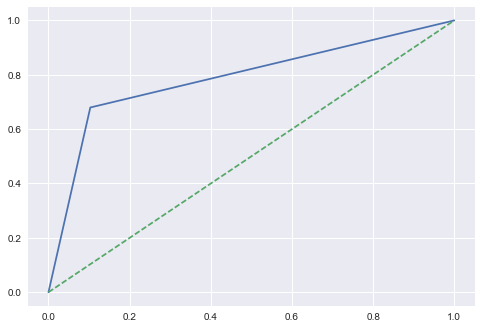

In [40]:
# Support Vector Machines
svm = SVC()
params = {"kernel": ["linear", "rbf"], "C": [1, 10, 100, 1000], "gamma": [1e-3, 1e-4]}
svm = tuneModel(svm, params)
acc_svm =scoreModel(svm)

Train accuracy score: 0.84911717496
Test accuracy score: 0.805970149254
Precision score 0.804448662469
Recall score 0.805970149254
F1 score 0.802844426125
Confusion matrix:
 [[146  19]
 [ 33  70]]


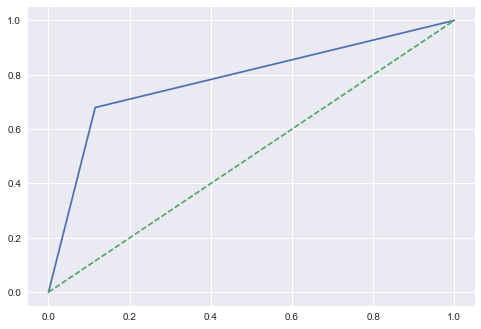

In [41]:
# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(attributes_train, labels_train)
acc_knn = scoreModel(knn)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Train accuracy score: 0.76886035313
Test accuracy score: 0.798507462687
Precision score 0.806070989159
Recall score 0.798507462687
F1 score 0.788885160784
Confusion matrix:
 [[154  11]
 [ 43  60]]


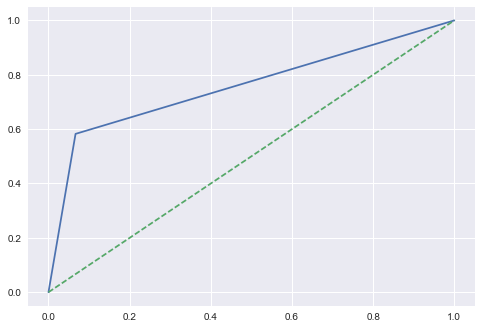

In [42]:
# Perceptron
perceptron = Perceptron()
params = {"penalty": [None, "l1", "l2"], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
perceptron = tuneModel(perceptron, params)
acc_perceptron = scoreModel(perceptron)

## Model evaluation

In [43]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'AdaBoost', 'Random Forest', 'Support Vector Machines', 'KNN', 'Perceptron'],
    'TrainScore': [acc_log[0], acc_tree[0], acc_ada[0], acc_forest[0], acc_svm[0], acc_knn[0], acc_perceptron[0]],
    'TestScore': [acc_log[1], acc_tree[1], acc_ada[1], acc_forest[1], acc_svm[1], acc_knn[1], acc_perceptron[1]]})
models.sort_values(by='TestScore', ascending=False)

,Model,TestScore,TrainScore
3,Random Forest,0.817164,0.855538
4,Support Vector Machines,0.813433,0.775281
0,Logistic Regression,0.809701,0.786517
5,KNN,0.805970,0.849117
6,Perceptron,0.798507,0.768860
1,Decision Tree,0.791045,0.849117
2,AdaBoost,0.787313,0.890851
